<a href="https://colab.research.google.com/github/edsolibet/tinymL/blob/main/sine_ml_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [3]:
!pip install tensorflow==2.4.1

In [3]:
import tensorflow as tf

from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m

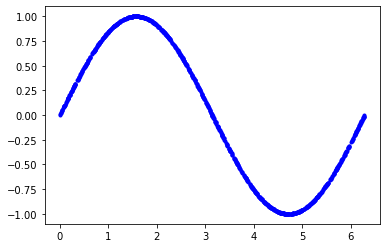

In [4]:
# generate data
samples = 1000
seed = 1337
np.random.seed(seed)
tf.random.set_seed(seed)

x_val = np.random.uniform(low = 0, high = 2*m.pi, size = samples)
np.random.shuffle(x_val)
y_val = np.sin(x_val)

plt.plot(x_val, y_val, 'b.')
plt.show()

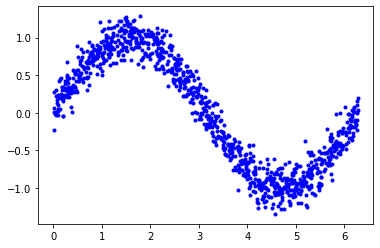

In [5]:
# add noise
y_val += 0.15 * np.random.randn(*y_val.shape)

plt.plot(x_val, y_val, 'b.')
plt.show()

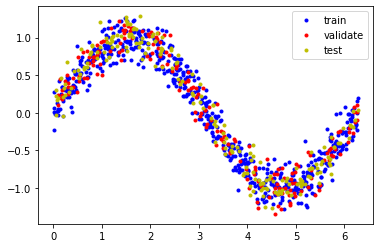

In [6]:
# split data
train_split = int(0.6 * samples)
test_split = int(0.2 * samples + train_split)

x_train, x_validate, x_test = np.split(x_val, [train_split, test_split])
y_train, y_validate, y_test = np.split(y_val, [train_split, test_split])

assert (x_train.size + x_validate.size + x_test.size) == samples

plt.plot(x_train, y_train, 'b.', label = 'train')
plt.plot(x_validate, y_validate, 'r.', label = 'validate')
plt.plot(x_test, y_test, 'y.', label = 'test')
plt.legend()
plt.show()

In [7]:
# define model architecture
model_1 = tf.keras.Sequential()

model_1.add(keras.layers.Dense(16, activation = 'relu', input_shape = (1,)))
model_1.add(keras.layers.Dense(16, activation = 'relu'))
model_1.add(keras.layers.Dense(1))
model_1.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

model_1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [8]:
# training them model
history_1 = model_1.fit(x_train, y_train, epochs = 1000, batch_size = 64,
                        validation_data = (x_validate, y_validate))

Epoch 1/1000
10/10 [==============================] - 1s 39ms/step - loss: 0.6165 - mae: 0.6410 - val_loss: 0.5452 - val_mae: 0.6114
Epoch 2/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.5183 - mae: 0.5958 - val_loss: 0.4675 - val_mae: 0.5751
Epoch 3/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.4220 - mae: 0.5467 - val_loss: 0.4286 - val_mae: 0.5562
Epoch 4/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.3801 - mae: 0.5282 - val_loss: 0.4164 - val_mae: 0.5571
Epoch 5/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.3707 - mae: 0.5296 - val_loss: 0.4087 - val_mae: 0.5532
Epoch 6/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.3765 - mae: 0.5303 - val_loss: 0.3975 - val_mae: 0.5439
Epoch 7/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.3573 - mae: 0.5177 - val_loss: 0.3862 - val_mae: 0.5315
Epoch 8/1000
10/10 [==============================] - 0s 5ms/step - loss: 0

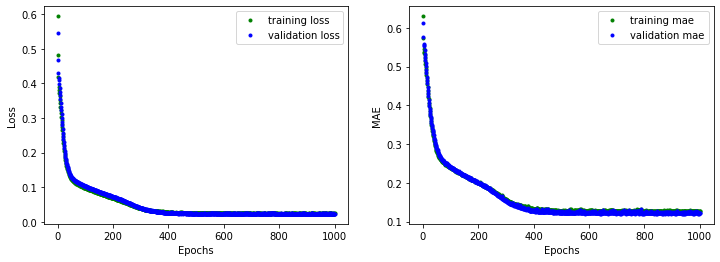

In [9]:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']
epochs = range(1, len(loss) + 1)
skip = 0

plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs[skip:], loss[skip:], 'g.', label = 'training loss')
plt.plot(epochs[skip:], val_loss[skip:], 'b.', label = 'validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs[skip:], mae[skip:], 'g.', label = 'training mae')
plt.plot(epochs[skip:], val_mae[skip:], 'b.', label = 'validation mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

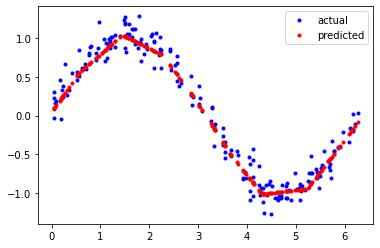

In [12]:
# prediction

predictions = model_1.predict(x_test)

plt.clf()
plt.plot(x_test, y_test, 'b.', label = 'actual')
plt.plot(x_test, predictions, 'r.', label = 'predicted')
plt.legend()
plt.show()

In [13]:
# convert model
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_generator():
  for value in x_test:
    yield [np.array(value, dtype = np.float32, ndmin = 2)]
converter.representative_dataset = representative_dataset_generator
tflite_model = converter.convert()

#save model
open("sine_model.tflite", 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpafwmg0tl/assets


INFO:tensorflow:Assets written to: /tmp/tmpafwmg0tl/assets


2896

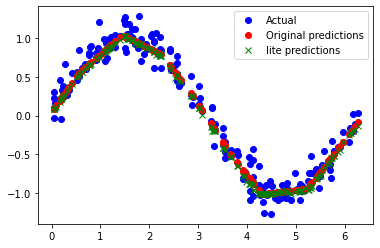

In [18]:
# instantitate an interpreter
sine_model = tf.lite.Interpreter('sine_model.tflite')
#allocate memory
sine_model.allocate_tensors()
#get indexes of the input and output tensors
sine_model_input_index = sine_model.get_input_details()[0]['index']
sine_model_output_index = sine_model.get_output_details()[0]['index']

# create arrays to store the results
sine_model_predictions = []

# run each model's interpreter for each value and store the results in arrays
for x in x_test:
  # create 2D tensor wrapping current x value
  x_value = tf.convert_to_tensor([[x]], dtype = np.float32)
  # write the value to the input tensor
  sine_model.set_tensor(sine_model_input_index, x_value)
  #run inference
  sine_model.invoke()
  # read the prediction from output tensor
  sine_model_predictions.append(sine_model.get_tensor(sine_model_output_index)[0])

plt.clf()
plt.plot(x_test, y_test, 'bo', label = 'Actual')
plt.plot(x_test, predictions, 'ro', label = 'Original predictions')
plt.plot(x_test, sine_model_predictions, 'gx', label = 'lite predictions')
plt.legend()
plt.show()

In [19]:
model_size = os.path.getsize('sine_model.tflite')
print("Quantized model is %d bytes" % model_size)

Quantized model is 2896 bytes
